In [1]:
import pandas as pd
from matplotlib import pyplot
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from category_encoders import OneHotEncoder
import pickle
import os
import joblib

In [2]:
%cd ../../

/Users/mubasir/Desktop/ONDC-hackathon


In [3]:
kolkata_store1_data = pd.read_csv(os.path.join("data", "store_data", "kol-str-1.csv"))
kolkata_store1_data.head()

,date,product name,p _ category,store_id,city / District,eonomical crisis,health crisis,festivals in region,weather,population density,lot size
0,01/01/2020,Rice,Consumable,kol-str-1,Kolkatta,Low,Low,New year,Winter,24760,120.0
1,01/02/2020,Rice,Consumable,kol-str-1,Kolkatta,Low,Low,NaN,Summer,24760,140.0
2,01/03/2020,Rice,Consumable,kol-str-1,Kolkatta,Low,Low,NaN,Summer,24760,130.0
3,01/04/2020,Rice,Consumable,kol-str-1,Kolkatta,Low,Medium,Holi,Summer,24760,130.0
4,01/05/2020,Rice,Consumable,kol-str-1,Kolkatta,Low,Medium,Eid,Summer,24760,140.0


In [4]:
kolkata_store1_data.sort_values(by = ["date"], inplace=True)
kolkata_store1_data

,date,product name,p _ category,store_id,city / District,eonomical crisis,health crisis,festivals in region,weather,population density,lot size
0,01/01/2020,Rice,Consumable,kol-str-1,Kolkatta,Low,Low,New year,Winter,24760,120.00
60,01/01/2020,Sanitizer,Consumable,kol-str-1,Kolkatta,Low,Low,New year,Winter,24760,0.14
36,01/01/2020,Cold drink,Consumable,kol-str-1,Kolkatta,Low,Low,New year,Winter,24760,13.00
72,01/01/2020,Mask,Non-Consumable,kol-str-1,Kolkatta,Low,Low,New year,Winter,24760,1.50
84,01/01/2020,Soap,Consumable,kol-str-1,Kolkatta,Low,Low,New year,Winter,24760,9.00
...,...,...,...,...,...,...,...,...,...,...,...
71,01/12/2020,Sanitizer,Consumable,kol-str-1,Kolkatta,Medium,Low,Christmas,Winter,24760,0.12
35,01/12/2020,Sugar,Consumable,kol-str-1,Kolkatta,Medium,Low,Christmas,Winter,24760,21.00
59,01/12/2020,Tea,Consumable,kol-str-1,Kolkatta,Medium,Low,Christmas,Winter,24760,18.00
11,01/12/2020,Rice,Consumable,kol-str-1,Kolkatta,Medium,Low,Christmas,Winter,24760,150.00


In [5]:
data = kolkata_store1_data.drop(columns=["date", "store_id", "city / District "])
data

,product name,p _ category,eonomical crisis,health crisis,festivals in region,weather,population density,lot size
0,Rice,Consumable,Low,Low,New year,Winter,24760,120.00
60,Sanitizer,Consumable,Low,Low,New year,Winter,24760,0.14
36,Cold drink,Consumable,Low,Low,New year,Winter,24760,13.00
72,Mask,Non-Consumable,Low,Low,New year,Winter,24760,1.50
84,Soap,Consumable,Low,Low,New year,Winter,24760,9.00
...,...,...,...,...,...,...,...,...
71,Sanitizer,Consumable,Medium,Low,Christmas,Winter,24760,0.12
35,Sugar,Consumable,Medium,Low,Christmas,Winter,24760,21.00
59,Tea,Consumable,Medium,Low,Christmas,Winter,24760,18.00
11,Rice,Consumable,Medium,Low,Christmas,Winter,24760,150.00


In [7]:
train, test = data[:len(data)], data[:len(data)]

In [9]:
train_X, ytrain = train.drop(columns=["lot size "], axis=1), train["lot size "]
test_X, ytest = test.drop(columns=["lot size "], axis=1), test["lot size "]

In [10]:
one_hot_encoder = OneHotEncoder().fit(train_X.drop(columns=["population density"], axis=1))
train_X_ohe = one_hot_encoder.transform(train_X.drop(columns=["population density"], axis=1))
test_X_ohe = one_hot_encoder.transform(test_X.drop(columns=["population density"], axis=1))

In [11]:
train_X_ohe.columns == test_X_ohe.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [12]:
INDIA_POPULATION = 1300000000
xtrain = pd.concat([train_X_ohe, train_X["population density"]/INDIA_POPULATION], axis = 1)
xtest = pd.concat([test_X_ohe, test_X["population density"]/INDIA_POPULATION], axis = 1)

In [13]:
filehandler = open(os.path.join("feature_encoder","one_hot_encoder.obj"),"wb")
pickle.dump(one_hot_encoder,filehandler)
filehandler.close()

In [14]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    

In [ ]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = metrics.mean_squared_error)
gsearch.fit(xtrain, ytrain)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = ytest.values
y_pred = best_model.predict(xtest)
regression_results(y_true, y_pred)

In [28]:
model_handler = open(os.path.join("trained_models","kol-str-1.pkl"),"wb")
pickle.dump(best_model,model_handler)
model_handler.close()

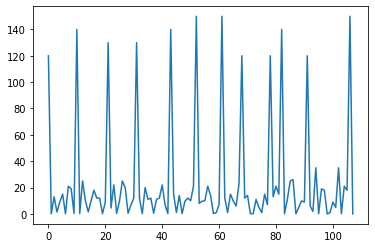

In [16]:
pyplot.plot(y_true)
pyplot.show()

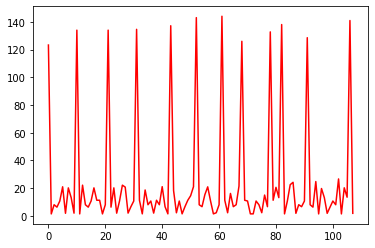

In [17]:
pyplot.plot(y_pred, color='red')
pyplot.show()

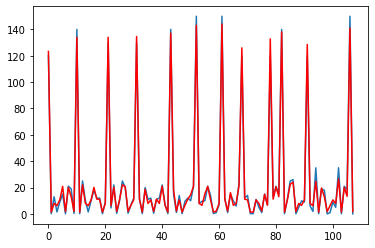

In [18]:
pyplot.plot(y_true)
pyplot.plot(y_pred, color='red')
pyplot.show()

In [20]:
train_X.iloc[0]

product name                  Rice
p _ category            Consumable
eonomical crisis               Low
health crisis                  Low
festivals in region      New year 
weather                     Winter
population density           24760
Name: 0, dtype: object

In [22]:
ytrain.iloc[0]

120.0

In [23]:
data_point = pd.DataFrame({
    "product name":["Rice"],
    'p _ category': ["Consumable"], 
    'eonomical crisis': ["Low"], 
    'health crisis': ["Low"], 
    'festivals in region ': [" New year "], 
    'weather': ["Winter"],
    'population density': [24760]
})

*Importing Saved Encoder*

In [24]:
encoder_file = open(os.path.join("feature_encoder","one_hot_encoder.obj"),'rb')
encoder_loaded = pickle.load(encoder_file)
encoder_file.close()

In [26]:
data_point_ohe = encoder_loaded.transform(data_point.drop(columns=["population density"], axis=1))
input_data_point = pd.concat([data_point_ohe, data_point["population density"]/INDIA_POPULATION], axis = 1)
input_data_point

,product name_1,product name_2,product name_3,product name_4,product name_5,product name_6,product name_7,product name_8,product name_9,p _ category_1,...,festivals in region _2,festivals in region _3,festivals in region _4,festivals in region _5,festivals in region _6,festivals in region _7,weather_1,weather_2,weather_3,population density
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0.000019


*Importing Saved Model*

In [27]:
model_file = open(os.path.join("trained_models","kol-str-1.pkl"),'rb')
model = pickle.load(model_file)
model_file.close()

In [29]:
model.predict(input_data_point)

array([128.61111111])